In [1]:
from gwpy.timeseries import TimeSeries
data1= TimeSeries.read('challenge3.gwf', 'H1:CHALLENGE3')
data2=TimeSeries.read('challenge3.gwf', 'L1:CHALLENGE3')

In [2]:
from pycbc.frame import read_frame

ts_H1 = read_frame("challenge3.gwf", "H1:CHALLENGE3")

print("Duration_H1: {}s delta_t_H1: {}s sampling rate_H1: {}Hz Start_H1: {} End_H1: {}".format(ts_H1.duration, ts_H1.delta_t, 1/ts_H1.delta_t,
                                              int(ts_H1.start_time),
                                              int(ts_H1.end_time)))

ts_L1 = read_frame("challenge3.gwf", "L1:CHALLENGE3")

print("Duration_L1: {}s delta_t_L1: {}s sampling rate_L1: {}Hz Start_L1: {} End_L1: {}".format(ts_L1.duration, ts_L1.delta_t, 1/ts_L1.delta_t,
                                              int(ts_L1.start_time),
                                              int(ts_L1.end_time)))

Duration_H1: 4096.0s delta_t_H1: 0.000244140625s sampling rate_H1: 4096.0Hz Start_H1: 0 End_H1: 4096
Duration_L1: 4096.0s delta_t_L1: 0.000244140625s sampling rate_L1: 4096.0Hz Start_L1: 0 End_L1: 4096


In [3]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

data_H1 = resample_to_delta_t(ts_H1, 1.0/2048).crop(2, 2)

p_H1 = data_H1.psd(2)
p_H1 = interpolate(p_H1, data_H1.delta_f)
p_H1 = inverse_spectrum_truncation(p_H1, 2 * data_H1.sample_rate, low_frequency_cutoff=15.0)
psd_H1 = p_H1

data_L1 = resample_to_delta_t(ts_L1, 1.0/2048).crop(2, 2)

p_L1 = data_L1.psd(2)
p_L1 = interpolate(p_L1, data_L1.delta_f)
p_L1 = inverse_spectrum_truncation(p_L1, 2 * data_L1.sample_rate, low_frequency_cutoff=15.0)
psd_L1 = p_L1
    

In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[34m'
   GREEN = '\033[32m'
   LIGHTGREEN = '\033[38;5;40m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   ITALICS = '\033[3m'
   ITAB = '\033[3;1m'
   BLUEB = '\033[34;1m'
   GREENB = '\033[32;1m'
   CYANB = '\033[36;1m' 
   BLIGHTGREEN = '\033[38;5;1;40m' 
   REDB = '\033[91;1m'

In [5]:
import numpy as np
from gwpy.timeseries import TimeSeries
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from colorama import Fore, Back, Style
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import matplotlib.pyplot as plt
import pandas as pd


Individual masses of the BBHs --  10 solar masses

Listing all the possible signal candidates(for BH mass= 10 solar mass) at Hanford in order of decreasing SNR

We found a possible signal candidate in H1 at 2483.96875 s with SNR 28.636095483196684
We found a possible signal candidate in H1 at 1204.71435546875 s with SNR 11.702049219693073
We found a possible signal candidate in H1 at 1638.17919921875 s with SNR 9.390212390406933



KeyboardInterrupt: 

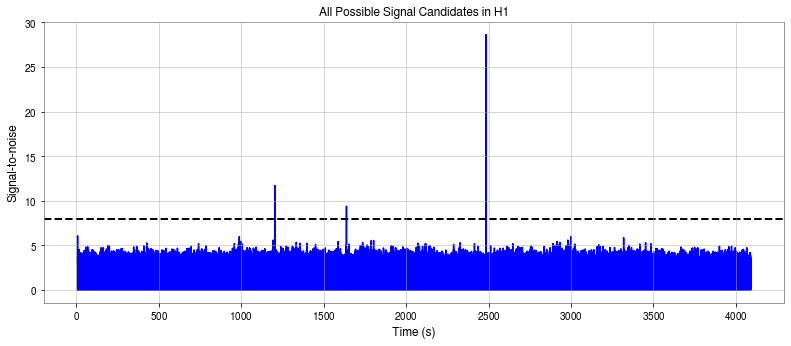

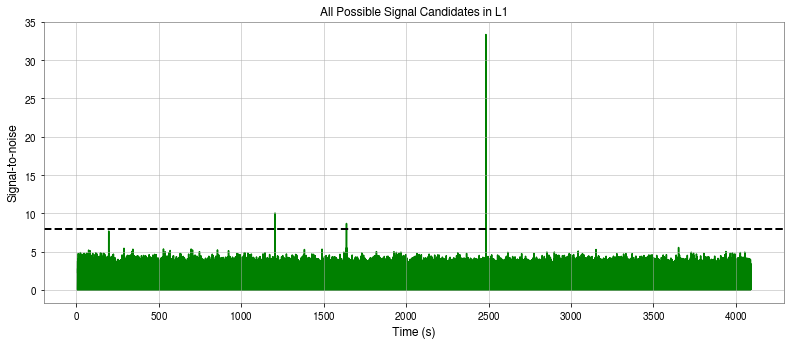

In [7]:
masses = []
dth = 8  # BBH merger signal threshold
BBH_dg = 750
# Assuming that for any apparent signal detected there will be no other merger
# peak within .36secs on either side of the said tentative detection as\
# it is implausible

nbins = 26  # for the reduced chisq filtering of removing glitches
dof = nbins * 2 - 2  # for the reduced chisq filtering of removing glitches

for x in range(10, 51):
    print(Style.RESET_ALL)
    print(color.BOLD + "Individual masses of the BBHs -- ", x, "solar masses" + color.END)
    print(Style.RESET_ALL)

    hp1, _ = get_fd_waveform(
        approximant="IMRPhenomD",
        mass1=x,
        mass2=x,
        delta_f=data_H1.delta_f,
        f_lower=20.0)

    hp1.resize(len(psd_H1))

    snr1 = matched_filter(hp1, data_H1, psd=psd_H1, low_frequency_cutoff=20)

    snr1 = snr1.crop(5, 4)
    peak1 = abs(snr1).numpy().argmax()
    snrp1 = snr1[peak1]
    time1 = snr1.sample_times[peak1]

    hp2, _ = get_fd_waveform(
        approximant="IMRPhenomD",
        mass1=x,
        mass2=x,
        delta_f=data_L1.delta_f,
        f_lower=20.0)

    hp2.resize(len(psd_L1))

    snr2 = matched_filter(hp2, data_L1, psd=psd_L1, low_frequency_cutoff=20)

    snr2 = snr2.crop(5, 4)
    peak2 = abs(snr2).numpy().argmax()
    snrp2 = snr2[peak2]
    time2 = snr2.sample_times[peak2]

    plt.figure(figsize=[13.27, 5.17])
    plt.plot(snr1.sample_times, abs(snr1), "-b")
    plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
    plt.title("All Possible Signal Candidates in H1")
    plt.ylabel("Signal-to-noise")
    plt.xlabel("Time (s)")
    #plt.show()
    plt.savefig("H1_value{x}.jpg".format(x=x))


    df_1 = pd.DataFrame({"snr1_x": snr1.sample_times, "snr1_y": abs(snr1).numpy()})

    maxv_snr1 = df_1["snr1_y"].max()
    max_i1 = df_1["snr1_y"].idxmax()
    snr1_xmax = df_1["snr1_x"][max_i1]
    snr1_ymax = df_1["snr1_y"][max_i1]

    if maxv_snr1 >= dth:
        print(
            color.BLUEB + "Listing all the possible signal candidates(for BH mass=", x, "solar mass) at Hanford in order of decreasing SNR" + color.END)
        print(Style.RESET_ALL)
        x_mx1l = []
        y_mx1l = []
        while maxv_snr1 >= dth:
            print(color.CYAN + "We found a possible signal candidate in H1 at", str(snr1_xmax), "s with SNR", str(snr1_ymax) + color.END)

            x_mx1l.append(snr1_xmax)
            y_mx1l.append(snr1_ymax)
            df_1 = df_1.drop(labels=range(max_i1 - BBH_dg, max_i1 + BBH_dg), axis=0)
            maxv_snr1 = df_1["snr1_y"].max()
            max_i1 = df_1["snr1_y"].idxmax()
            snr1_xmax = df_1["snr1_x"][max_i1]
            snr1_ymax = df_1["snr1_y"][max_i1]

        print(Style.RESET_ALL)

        x_mx1ar = np.asarray(x_mx1l)
        y_mx1ar = np.asarray(y_mx1l)
        dfo_1 = (pd.DataFrame({"x1": x_mx1ar, "y1": y_mx1ar}).sort_values("x1").reset_index())

    else:
        print(color.BLUEB + "There were no signal candidates at Hanford" + color.END)
        print(Style.RESET_ALL)

    plt.figure(figsize=[13.27, 5.17])
    plt.plot(snr2.sample_times, abs(snr2), "-g")
    plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
    plt.title("All Possible Signal Candidates in L1")
    plt.ylabel("Signal-to-noise")
    plt.xlabel("Time (s)")
    #plt.show()
    plt.savefig("L1_value{x}.jpg".format(x=x))

    df_2 = pd.DataFrame({"snr2_x": snr2.sample_times, "snr2_y": abs(snr2).numpy()})

    maxv_snr2 = df_2["snr2_y"].max()
    max_i2 = df_2["snr2_y"].idxmax()
    snr2_xmax = df_2["snr2_x"][max_i2]
    snr2_ymax = df_2["snr2_y"][max_i2]

    if maxv_snr2 >= dth:
        print(color.GREENB + "Listing all the possible signal candidates(for BH mass=", x, "solar mass) at Livingston in order of decreasing SNR" + color.END)
        print(Style.RESET_ALL)
        x_mx2l = []
        y_mx2l = []
        while maxv_snr2 >= dth:
            print(color.LIGHTGREEN + "We found a possible signal candidate in L1 at", str(snr2_xmax), "s with SNR", str(snr2_ymax) + color.END)

            x_mx2l.append(snr2_xmax)
            y_mx2l.append(snr2_ymax)
            df_2 = df_2.drop(labels=range(max_i2 - BBH_dg, max_i2 + BBH_dg), axis=0)
            maxv_snr2 = df_2["snr2_y"].max()
            max_i2 = df_2["snr2_y"].idxmax()
            snr2_xmax = df_2["snr2_x"][max_i2]
            snr2_ymax = df_2["snr2_y"][max_i2]

        print(Style.RESET_ALL)

        x_mx2ar = np.asarray(x_mx2l)
        y_mx2ar = np.asarray(y_mx2l)
        dfo_2 = (pd.DataFrame({"x2": x_mx2ar, "y2": y_mx2ar}).sort_values("x2").reset_index())
    else:
        print(color.GREENB + "There were no signal candidates at Livingston" + color.END)
        print(Style.RESET_ALL)

    chisq_H1 = power_chisq(hp1, data_H1, nbins, psd_H1, low_frequency_cutoff=20.0)
    chisq_H1 = chisq_H1.crop(5, 4)
    chisq_H1 /= dof
    nsnr1 = newsnr(abs(snr1), chisq_H1)
    peak_H1 = nsnr1.argmax()
    snrp_H1 = nsnr1[peak_H1]
    time_H1 = snr1.sample_times[peak_H1]

    chisq_L1 = power_chisq(hp2, data_L1, nbins, psd_L1, low_frequency_cutoff=20.0)
    chisq_L1 = chisq_L1.crop(5, 4)
    chisq_L1 /= dof
    nsnr2 = newsnr(abs(snr2), chisq_L1)
    peak_L1 = nsnr2.argmax()
    snrp_L1 = nsnr2[peak_L1]
    time_L1 = snr2.sample_times[peak_L1]

    if snrp_H1 > dth:
        # print("For the Hanford data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_H1, abs(snrp_H1)))
        # print(Style.RESET_ALL)
        plt.figure(figsize=[13.27, 5.17])
        plt.plot(snr1.sample_times, nsnr1, "-b")
        plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
        plt.title("Remaining Signal Candidate in H1 after reweighing data")
        plt.xlabel("Time (s)")
        plt.ylabel("Re-weighted Signal-to-noise")
        plt.show()

        ndf_1 = pd.DataFrame({"x1": snr1.sample_times, "y1": nsnr1})
        max_value1 = ndf_1["y1"].max()
        max_index1 = ndf_1["y1"].idxmax()
        x_max1 = ndf_1["x1"][max_index1]
        y_max1 = ndf_1["y1"][max_index1]

        if max_value1 >= dth:
            # print(color.BOLD + "Listing all the remaining signal candidate(s) at Hanford" + color.END)
            # print(Style.RESET_ALL)
            x_max1l = []
            y_max1l = []
            while max_value1 >= dth:
                # print("We found a confirmed signal candidate in H1 at", x_max1,"s with SNR", y_max1)
                x_max1l.append(x_max1)
                y_max1l.append(y_max1)
                ndf_1 = ndf_1.drop(labels=range(max_index1 - BBH_dg, max_index1 + BBH_dg), axis=0)
                max_value1 = ndf_1["y1"].max()
                max_index1 = ndf_1["y1"].idxmax()
                x_max1 = ndf_1["x1"][max_index1]
                y_max1 = ndf_1["y1"][max_index1]

            x_max1ar = np.asarray(x_max1l)
            y_max1ar = np.asarray(y_max1l)
            dfn_1 = (pd.DataFrame({"X1": x_max1ar, "Y1": y_max1ar}).sort_values("X1").reset_index())
            cond1 = dfo_1["x1"].isin(dfn_1["X1"])  # condition for extracting glitches in H1
            dfo_gl1 = dfo_1.drop(dfo_1[cond1].index, inplace=False)  # glitch dataframe for H1
            dfo_gl1 = dfo_gl1.reset_index()

    else:
        print(color.BLUEB + "There were no signal candidates at Hanford for template using m1=m2=", x, "solar masses" + color.END)
        print(Style.RESET_ALL)
        dfo_gl1 = dfo_1
        dfn_1 = []

    if snrp_L1 > dth:
        # print("For the Livingston data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_L1, abs(snrp_L1)))
        # print(Style.RESET_ALL)
        plt.figure(figsize=[13.27, 5.17])
        plt.plot(snr2.sample_times, nsnr2, "-g")
        plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
        plt.title("Remaining Signal Candidate in L1 after reweighing data")
        plt.xlabel("Time (s)")
        plt.ylabel("Re-weighted Signal-to-noise")
        plt.show()

        ndf_2 = pd.DataFrame({"x2": snr2.sample_times, "y2": nsnr2})
        max_value2 = ndf_2["y2"].max()
        max_index2 = ndf_2["y2"].idxmax()
        x_max2 = ndf_2["x2"][max_index2]
        y_max2 = ndf_2["y2"][max_index2]

        if max_value2 >= dth:
            # print(color.BOLD + "Listing all the remaining signal candidate(s) at Livingston" + color.END)
            # print(Style.RESET_ALL)
            x_max2l = []
            y_max2l = []
            while max_value2 >= dth:
                # print("We found a confirmed signal candidate in L1 at", x_max2,"s with SNR", y_max2)

                x_max2l.append(x_max2)
                y_max2l.append(y_max2)
                ndf_2 = ndf_2.drop(labels=range(max_index2 - BBH_dg, max_index2 + BBH_dg), axis=0)
                max_value2 = ndf_2["y2"].max()
                max_index2 = ndf_2["y2"].idxmax()
                x_max2 = ndf_2["x2"][max_index2]
                y_max2 = ndf_2["y2"][max_index2]

            x_max2ar = np.asarray(x_max2l)
            y_max2ar = np.asarray(y_max2l)
            dfn_2 = (pd.DataFrame({"X2": x_max2ar, "Y2": y_max2ar}).sort_values("X2").reset_index())
            cond2 = dfo_2["x2"].isin(dfn_2["X2"])  # condition for extracting glitches in L1
            dfo_gl2 = dfo_2.drop(dfo_2[cond2].index, inplace=False)  # glitch dataframe for L1
            dfo_gl2 = dfo_gl2.reset_index()

    else:
        print(color.GREENB + "There were no signal candidates at Livingston for template using m1=m2=", x, "solar masses" + color.END)
        print(Style.RESET_ALL)
        dfo_gl2 = dfo_2
        dfn_2 = []

    ############################################################
    ############################################################
    if (snrp_H1 > dth) or (snrp_L1 > dth) or ((snrp_H1 > dth) and (snrp_L1 > dth)):

        if len(dfn_1) > 0 and len(dfn_2) == 0:
            print(color.BLUEB + "There are no surviving signal candidates in L1 whereas for H1 we have", len(dfn_1), "candidates:" + color.END)
            print(Style.RESET_ALL)
            for i in range(0, dfn_1.index[-1] + 1):
                print(color.CYAN + "The signal candidate in H1 at", str(dfn_1["X1"][i]), "has a SNR of", str(dfn_1["Y1"][i]) + color.END)
            print(Style.RESET_ALL)
            print(color.GREENB + "The following signal candidates in L1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)
            for b in range(0, dfo_2.index[-1] + 1):
                print(color.LIGHTGREEN + "The initial signal candidate at L1 reported at", str(dfo_2["x2"][b]), "was a glitch" + color.END)

        elif len(dfn_2) > 0 and len(dfn_1) == 0:
            print(color.GREENB + "There are no surviving signal candidates in H1 whereas for L1 we have", len(dfn_2), "candidates:" + color.END)
            print(Style.RESET_ALL)
            for j in range(0, dfn_2.index[-1] + 1):
                print(color.LIGHTGREEN + "The signal candidate in L1 at", str(dfn_2["X2"][j]), "has a SNR of", str(dfn_2["Y2"][j]) + color.END)
            print(Style.RESET_ALL)
            print(color.BLUEB + "The following signal candidates in H1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)
            for a in range(0, dfo_1.index[-1] + 1):
                print(color.CYAN + "The initial signal candidate at H1 reported at", str(dfo_1["x1"][a]), "was a glitch" + color.END)

        elif len(dfn_2) > 0 and len(dfn_1) > 0:
            print(color.BLUEB + "The following signal candidates in H1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)

            if len(dfo_gl1) != 0:
                for g1 in range(0, dfo_gl1.index[-1] + 1):
                    print(color.CYAN + "The initial signal candidate at H1 reported at", str(dfo_gl1["x1"][g1]), "was a glitch" + color.END)
            if len(dfo_gl1) < len(dfo_1):
                print(Style.RESET_ALL)
                print(color.BLUEB + "The surviving signal candidates in H1 are:" + color.END)
                print(Style.RESET_ALL)
                for i in range(0, dfn_1.index[-1] + 1):
                    print(color.CYAN + "There is a signal candidate in H1 at", str(dfn_1["X1"][i]), "with SNR", str(dfn_1["Y1"][i]) + color.END)

            print(Style.RESET_ALL)
            print(color.GREENB + "The following signal candidates in L1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)

            if len(dfo_gl2) != 0:
                for g2 in range(0, dfo_gl2.index[-1] + 1):
                    print(color.LIGHTGREEN + "The initial signal candidate at L1 reported at", str(dfo_gl2["x2"][g2]), "was a glitch" + color.END)
            if len(dfo_gl2) < len(dfo_2):
                print(Style.RESET_ALL)
                print(color.GREENB + "The surviving signal candidates in L1 are:" + color.END)
                print(Style.RESET_ALL)
                for j in range(0, dfn_2.index[-1] + 1):
                    print(color.LIGHTGREEN + "There is a signal candidate in L1 at", str(dfn_2["X2"][j]), "with SNR", str(dfn_2["Y2"][j]) + color.END)

            print(Style.RESET_ALL)
            print(color.BOLD + "Checking if the surviving signal candidates fit the criteria for a BBH merger for our chosen template:" + color.END)
            # print(Style.RESET_ALL)

            for i in range(0, dfn_1.index[-1] + 1):
                for j in range(0, dfn_2.index[-1] + 1):

                    if abs(dfn_2["X2"][j] - dfn_1["X1"][i]) > 3:
                        print(Style.RESET_ALL)
                        print(color.BOLD + "The signals at", str(dfn_1["X1"][i]), "for H1 and at", str(dfn_2["X2"][j]), "for L1 are too far apart with a lag of", str(abs(dfn_2["X2"][j] - dfn_1["X1"][i])), "s" + color.END)

                    elif dfn_1["X1"][i] == dfn_2["X2"][j]:
                        print(Style.RESET_ALL)
                        print(color.BOLD + "As the timestamps are exactly same we conclude an injected signal mimicking a BBH merger at", str(dfn_1["X1"][i]), "\nwith the H1 SNR", str(dfn_1["Y1"][i]), "and the L1 SNR", str(dfn_2["Y2"][j]) + color.END)
                        print(Style.RESET_ALL)

                    elif abs(dfn_2["X2"][j] - dfn_1["X1"][i]) < 0.008961194:
                        # print(Style.RESET_ALL)
                        print(color.BOLD + "The time lag", str(abs(dfn_2["X2"][j] - dfn_1["X1"][i])), "s between the signals at H1 & L1 is too short compared to GW travel time and hence \nan artefact of other noise sources or some artificial source" + color.END)
                        print(Style.RESET_ALL)

                    elif dfn_2["X2"][j] - 3 <= dfn_1["X1"][i] <= dfn_2["X2"][j] + 3:
                        if abs(dfn_2["X2"][j] - dfn_1["X1"][i]) > 0.011328301:
                            print(Style.RESET_ALL)
                            print(color.BOLD + "While the time lag", str(abs(dfn_2["X2"][j] - dfn_1["X1"][i])), "s is short it is too large compared to GW travel time and hence an artefact of other noise sources" + color.END)
                            print(Style.RESET_ALL)

                    elif (dfn_2["X2"][j] - 0.008961194 <= dfn_1["X1"][i] <= dfn_2["X2"][j] + 0.008961194):
                        print(Style.RESET_ALL)
                        print(color.CYAN + "We found a BBH merger candidate \nin H1 at", str(dfn_1["X1"][i]), "with SNR", str(dfn_1["Y1"][i]), "and \nin L1 at", str(dfn_2["X2"][j]), "with SNR", str(dfn_2["Y2"][j]) + color.END)
                        print(Style.RESET_ALL)

                    elif (abs(dfn_2["X2"][j] - dfn_1["X1"][i]) >= 0.008961194) and (abs(dfn_2["X2"][j] - dfn_1["X1"][i]) < 0.011328301):
                        print(Style.RESET_ALL)
                        print(color.BLUEB + "We found a signal candidate \nin H1 at", str(dfn_1["X1"][i]), "with SNR", str(dfn_1["Y1"][i]), "and \nin L1 at", str(dfn_2["X2"][j]), "with SNR", str(dfn_2["Y2"][j]) + color.END)
                        print(color.BOLD + "The above signal is an extremely likely candidate for an authentic BBH merger given the choice of template" + color.END)
                        print(color.BOLD + "The time lag", str(abs(dfn_2["X2"][j] - dfn_1["X1"][i])), "s between the signals at H1 & L1 is comparable to GW travel time" + color.END)
                        # print(Style.RESET_ALL)
                    else:
                        print(color.BLUEB + "yipee" + color.END)

    else:
        # print("Glitches and remaining signals")
        print(Style.RESET_ALL)
        # if len(dfn_1) == 0 and len(dfn_2) == 0:
        print(color.REDB + "There are no remaining signal candidates in both H1 and L1" + color.END)
        print(Style.RESET_ALL)
        for a in range(0, dfo_1.index[-1] + 1):
            print(color.CYAN + "The initial signal candidate at H1 reported at", str(dfo_1["x1"][a]), "was a glitch" + color.END)
        print(Style.RESET_ALL)
        for b in range(0, dfo_2.index[-1] + 1):
            print(color.LIGHTGREEN + "The initial signal candidate at L1 reported at", str(dfo_2["x2"][b]), "was a glitch" + color.END)

    ############################################################
    ############################################################
    
    masses.append(x)

In [7]:
masses = []
dth = 8  # BBH merger signal threshold
BBH_dg = 750
# Assuming that for any apparent signal detected there will be no other merger
# peak within .36secs on either side of the said tentative detection as\
# it is implausible

nbins = 26  # for the reduced chisq filtering of removing glitches
dof = nbins * 2 - 2  # for the reduced chisq filtering of removing glitches

for x in range(10, 12):
    print(Style.RESET_ALL)
    print(color.BOLD + "Individual masses of the BBHs -- ", x, "solar masses" + color.END)
    print(Style.RESET_ALL)

    hp1, _ = get_fd_waveform(
        approximant="IMRPhenomD",
        mass1=x,
        mass2=x,
        delta_f=data_H1.delta_f,
        f_lower=20.0)

    hp1.resize(len(psd_H1))

    snr1 = matched_filter(hp1, data_H1, psd=psd_H1, low_frequency_cutoff=20)

    snr1 = snr1.crop(5, 4)
    peak1 = abs(snr1).numpy().argmax()
    snrp1 = snr1[peak1]
    time1 = snr1.sample_times[peak1]

    hp2, _ = get_fd_waveform(
        approximant="IMRPhenomD",
        mass1=x,
        mass2=x,
        delta_f=data_L1.delta_f,
        f_lower=20.0)

    hp2.resize(len(psd_L1))

    snr2 = matched_filter(hp2, data_L1, psd=psd_L1, low_frequency_cutoff=20)

    snr2 = snr2.crop(5, 4)
    peak2 = abs(snr2).numpy().argmax()
    snrp2 = snr2[peak2]
    time2 = snr2.sample_times[peak2]

    plt.figure(figsize=[13.27, 5.17])
    plt.plot(snr1.sample_times, abs(snr1), "-b")
    plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
    plt.title("All Possible Signal Candidates in H1")
    plt.ylabel("Signal-to-noise")
    plt.xlabel("Time (s)")
    plt.show()

    df_1 = pd.DataFrame({"snr1_x": snr1.sample_times, "snr1_y": abs(snr1).numpy()})

    maxv_snr1 = df_1["snr1_y"].max()
    max_i1 = df_1["snr1_y"].idxmax()
    snr1_xmax = df_1["snr1_x"][max_i1]
    snr1_ymax = df_1["snr1_y"][max_i1]

    if maxv_snr1 >= dth:
        print(
            color.BLUEB + "Listing all the possible signal candidates(for BH mass=", x, "solar mass) at Hanford in order of decreasing SNR" + color.END)
        print(Style.RESET_ALL)
        x_mx1l = []
        y_mx1l = []
        while maxv_snr1 >= dth:
            print(color.CYAN + "We found a possible signal candidate in H1 at", str(snr1_xmax), "s with SNR", str(snr1_ymax) + color.END)

            x_mx1l.append(snr1_xmax)
            y_mx1l.append(snr1_ymax)
            df_1 = df_1.drop(labels=range(max_i1 - BBH_dg, max_i1 + BBH_dg), axis=0)
            maxv_snr1 = df_1["snr1_y"].max()
            max_i1 = df_1["snr1_y"].idxmax()
            snr1_xmax = df_1["snr1_x"][max_i1]
            snr1_ymax = df_1["snr1_y"][max_i1]

        print(Style.RESET_ALL)

        x_mx1ar = np.asarray(x_mx1l)
        y_mx1ar = np.asarray(y_mx1l)
        dfo_1 = (pd.DataFrame({"x1": x_mx1ar, "y1": y_mx1ar}).sort_values("x1").reset_index())

    else:
        print(color.BLUEB + "There were no signal candidates at Hanford" + color.END)
        print(Style.RESET_ALL)

    plt.figure(figsize=[13.27, 5.17])
    plt.plot(snr2.sample_times, abs(snr2), "-g")
    plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
    plt.title("All Possible Signal Candidates in L1")
    plt.ylabel("Signal-to-noise")
    plt.xlabel("Time (s)")
    plt.show()

    df_2 = pd.DataFrame({"snr2_x": snr2.sample_times, "snr2_y": abs(snr2).numpy()})

    maxv_snr2 = df_2["snr2_y"].max()
    max_i2 = df_2["snr2_y"].idxmax()
    snr2_xmax = df_2["snr2_x"][max_i2]
    snr2_ymax = df_2["snr2_y"][max_i2]

    if maxv_snr2 >= dth:
        print(color.GREENB + "Listing all the possible signal candidates(for BH mass=", x, "solar mass) at Livingston in order of decreasing SNR" + color.END)
        print(Style.RESET_ALL)
        x_mx2l = []
        y_mx2l = []
        while maxv_snr2 >= dth:
            print(color.LIGHTGREEN + "We found a possible signal candidate in L1 at", str(snr2_xmax), "s with SNR", str(snr2_ymax) + color.END)

            x_mx2l.append(snr2_xmax)
            y_mx2l.append(snr2_ymax)
            df_2 = df_2.drop(labels=range(max_i2 - BBH_dg, max_i2 + BBH_dg), axis=0)
            maxv_snr2 = df_2["snr2_y"].max()
            max_i2 = df_2["snr2_y"].idxmax()
            snr2_xmax = df_2["snr2_x"][max_i2]
            snr2_ymax = df_2["snr2_y"][max_i2]

        print(Style.RESET_ALL)

        x_mx2ar = np.asarray(x_mx2l)
        y_mx2ar = np.asarray(y_mx2l)
        dfo_2 = (pd.DataFrame({"x2": x_mx2ar, "y2": y_mx2ar}).sort_values("x2").reset_index())
    else:
        print(color.GREENB + "There were no signal candidates at Livingston" + color.END)
        print(Style.RESET_ALL)

    chisq_H1 = power_chisq(hp1, data_H1, nbins, psd_H1, low_frequency_cutoff=20.0)
    chisq_H1 = chisq_H1.crop(5, 4)
    chisq_H1 /= dof
    nsnr1 = newsnr(abs(snr1), chisq_H1)
    peak_H1 = nsnr1.argmax()
    snrp_H1 = nsnr1[peak_H1]
    time_H1 = snr1.sample_times[peak_H1]

    chisq_L1 = power_chisq(hp2, data_L1, nbins, psd_L1, low_frequency_cutoff=20.0)
    chisq_L1 = chisq_L1.crop(5, 4)
    chisq_L1 /= dof
    nsnr2 = newsnr(abs(snr2), chisq_L1)
    peak_L1 = nsnr2.argmax()
    snrp_L1 = nsnr2[peak_L1]
    time_L1 = snr2.sample_times[peak_L1]

    if snrp_H1 > dth:
        # print("For the Hanford data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_H1, abs(snrp_H1)))
        # print(Style.RESET_ALL)
        plt.figure(figsize=[13.27, 5.17])
        plt.plot(snr1.sample_times, nsnr1, "-b")
        plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
        plt.title("Remaining Signal Candidate in H1 after reweighing data")
        plt.xlabel("Time (s)")
        plt.ylabel("Re-weighted Signal-to-noise")
        plt.show()

        ndf_1 = pd.DataFrame({"x1": snr1.sample_times, "y1": nsnr1})
        max_value1 = ndf_1["y1"].max()
        max_index1 = ndf_1["y1"].idxmax()
        x_max1 = ndf_1["x1"][max_index1]
        y_max1 = ndf_1["y1"][max_index1]

        if max_value1 >= dth:
            # print(color.BOLD + "Listing all the remaining signal candidate(s) at Hanford" + color.END)
            # print(Style.RESET_ALL)
            x_max1l = []
            y_max1l = []
            while max_value1 >= dth:
                
                x_max1l.append(x_max1)
                y_max1l.append(y_max1)
                ndf_1 = ndf_1.drop(labels=range(max_index1 - BBH_dg, max_index1 + BBH_dg), axis=0)
                max_value1 = ndf_1["y1"].max()
                max_index1 = ndf_1["y1"].idxmax()
                x_max1 = ndf_1["x1"][max_index1]
                y_max1 = ndf_1["y1"][max_index1]

            x_max1ar = np.asarray(x_max1l)
            y_max1ar = np.asarray(y_max1l)
            dfn_1 = (pd.DataFrame({"X1": x_max1ar, "Y1": y_max1ar}).sort_values("X1").reset_index())
            cond1 = dfo_1["x1"].isin(dfn_1["X1"])  # condition for extracting glitches in H1
            dfo_gl1 = dfo_1.drop(dfo_1[cond1].index, inplace=False)  # glitch dataframe for H1
            dfo_gl1 = dfo_gl1.reset_index()

    else:
        print(color.BLUEB + "There were no signal candidates at Hanford for template using m1=m2=", x, "solar masses" + color.END)
        print(Style.RESET_ALL)
        dfo_gl1 = dfo_1
        dfn_1 = []

    if snrp_L1 > dth:
        # print("For the Livingston data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_L1, abs(snrp_L1)))
        # print(Style.RESET_ALL)
        plt.figure(figsize=[13.27, 5.17])
        plt.plot(snr2.sample_times, nsnr2, "-g")
        plt.axhline(y=8, color="black", linestyle="dashed", lw=2)
        plt.title("Remaining Signal Candidate in L1 after reweighing data")
        plt.xlabel("Time (s)")
        plt.ylabel("Re-weighted Signal-to-noise")
        plt.show()

        ndf_2 = pd.DataFrame({"x2": snr2.sample_times, "y2": nsnr2})
        max_value2 = ndf_2["y2"].max()
        max_index2 = ndf_2["y2"].idxmax()
        x_max2 = ndf_2["x2"][max_index2]
        y_max2 = ndf_2["y2"][max_index2]

        if max_value2 >= dth:
            # print(color.BOLD + "Listing all the remaining signal candidate(s) at Livingston" + color.END)
            # print(Style.RESET_ALL)
            x_max2l = []
            y_max2l = []
            while max_value2 >= dth:
                
                x_max2l.append(x_max2)
                y_max2l.append(y_max2)
                ndf_2 = ndf_2.drop(labels=range(max_index2 - BBH_dg, max_index2 + BBH_dg), axis=0)
                max_value2 = ndf_2["y2"].max()
                max_index2 = ndf_2["y2"].idxmax()
                x_max2 = ndf_2["x2"][max_index2]
                y_max2 = ndf_2["y2"][max_index2]

            x_max2ar = np.asarray(x_max2l)
            y_max2ar = np.asarray(y_max2l)
            dfn_2 = (pd.DataFrame({"X2": x_max2ar, "Y2": y_max2ar}).sort_values("X2").reset_index())
            cond2 = dfo_2["x2"].isin(dfn_2["X2"])  # condition for extracting glitches in L1
            dfo_gl2 = dfo_2.drop(dfo_2[cond2].index, inplace=False)  # glitch dataframe for L1
            dfo_gl2 = dfo_gl2.reset_index()

    else:
        print(color.GREENB + "There were no signal candidates at Livingston for template using m1=m2=", x, "solar masses" + color.END)
        print(Style.RESET_ALL)
        dfo_gl2 = dfo_2
        dfn_2 = []

    if (snrp_H1 > dth) or (snrp_L1 > dth) or ((snrp_H1 > dth) and (snrp_L1 > dth)):

        if len(dfn_1) > 0 and len(dfn_2) == 0:
            print(color.BLUEB + "There are no surviving signal candidates in L1 whereas for H1 we have", len(dfn_1), "candidates:" + color.END)
            print(Style.RESET_ALL)
            for i in range(0, dfn_1.index[-1] + 1):
                print(color.CYAN + "The signal candidate in H1 at", str(dfn_1["X1"][i]), "has a SNR of", str(dfn_1["Y1"][i]) + color.END)
            print(Style.RESET_ALL)
            print(color.GREENB + "The following signal candidates in L1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)
            for b in range(0, dfo_2.index[-1] + 1):
                print(color.LIGHTGREEN + "The initial signal candidate at L1 reported at", str(dfo_2["x2"][b]), "was a glitch" + color.END)

        elif len(dfn_2) > 0 and len(dfn_1) == 0:
            print(color.GREENB + "There are no surviving signal candidates in H1 whereas for L1 we have", len(dfn_2), "candidates:" + color.END)
            print(Style.RESET_ALL)
            for j in range(0, dfn_2.index[-1] + 1):
                print(color.LIGHTGREEN + "The signal candidate in L1 at", str(dfn_2["X2"][j]), "has a SNR of", str(dfn_2["Y2"][j]) + color.END)
            print(Style.RESET_ALL)
            print(color.BLUEB + "The following signal candidates in H1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)
            for a in range(0, dfo_1.index[-1] + 1):
                print(color.CYAN + "The initial signal candidate at H1 reported at", str(dfo_1["x1"][a]), "was a glitch" + color.END)

        elif len(dfn_2) > 0 and len(dfn_1) > 0:
            print(color.BLUEB + "The following signal candidates in H1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)

            if len(dfo_gl1) != 0:
                for g1 in range(0, dfo_gl1.index[-1] + 1):
                    print(color.CYAN + "The initial signal candidate at H1 reported at", str(dfo_gl1["x1"][g1]), "was a glitch" + color.END)
            if len(dfo_gl1) < len(dfo_1):
                print(Style.RESET_ALL)
                print(color.BLUEB + "The surviving signal candidates in H1 are:" + color.END)
                print(Style.RESET_ALL)
                for i in range(0, dfn_1.index[-1] + 1):
                    print(color.CYAN + "There is a signal candidate in H1 at", str(dfn_1["X1"][i]), "with SNR", str(dfn_1["Y1"][i]) + color.END)

            print(Style.RESET_ALL)
            print(color.GREENB + "The following signal candidates in L1 were ruled out as glitches:" + color.END)
            print(Style.RESET_ALL)

            if len(dfo_gl2) != 0:
                for g2 in range(0, dfo_gl2.index[-1] + 1):
                    print(color.LIGHTGREEN + "The initial signal candidate at L1 reported at", str(dfo_gl2["x2"][g2]), "was a glitch" + color.END)
            if len(dfo_gl2) < len(dfo_2):
                print(Style.RESET_ALL)
                print(color.GREENB + "The surviving signal candidates in L1 are:" + color.END)
                print(Style.RESET_ALL)
                for j in range(0, dfn_2.index[-1] + 1):
                    print(color.LIGHTGREEN + "There is a signal candidate in L1 at", str(dfn_2["X2"][j]), "with SNR", str(dfn_2["Y2"][j]) + color.END)

            print(Style.RESET_ALL)
            print(color.BOLD +"Checking if the surviving signal candidates fit the criteria for a BBH merger for our chosen template:" + color.END)
            #print(Style.RESET_ALL)
    
            for i in range(0,dfn_1.index[-1]+1): 
                for j in range(0,dfn_2.index[-1]+1):              

                    if dfn_1['X1'][i] == dfn_2['X2'][j]:
                        print(Style.RESET_ALL)  
                        print(color.BOLD + "As the timestamps are exactly same we conclude an injected signal mimicking a BBH merger at", dfn_1['X1'][i], 
                              "\nwith the H1 SNR", dfn_1['Y1'][i], "and the L1 SNR", dfn_2['Y2'][j], "." + color.END)
                        print(Style.RESET_ALL)  

                    elif dfn_2['X2'][j]-0.008961194 <= dfn_1['X1'][i] <= dfn_2['X2'][j]+0.008961194:

                        print(Style.RESET_ALL)
                        print(color.BOLD + "We found a BBH merger candidate \nin H1 at", dfn_1['X1'][i], "with SNR",dfn_1['Y1'][i],
                              "and \nin L1 at",dfn_2['X2'][j], "with SNR",dfn_2['Y2'][j], "." + color.END)
                        print(Style.RESET_ALL)

                        if abs(dfn_2['X2'][j]-dfn_1['X1'][i]) < 0.008961194:
                            #print(Style.RESET_ALL)
                            print(color.BOLD + "The time lag",abs(dfn_2['X2'][j]-dfn_1['X1'][i]) ,"s between the signals at H1 & L1 is too short compared to GW travel time and hence \nan artefact of other noise sources or some artificial source" + color.END)
                            print(Style.RESET_ALL)

                        else:
                            print(color.BLUEB + "yipee" + color.END)

                    elif dfn_2['X2'][j]-3 <= dfn_1['X1'][i] <= dfn_2['X2'][j]+3:

                        if abs(dfn_2['X2'][j]-dfn_1['X1'][i]) > 0.011328301:
                            print(Style.RESET_ALL)
                            print(color.BOLD + "While the time lag",abs(dfn_2['X2'][j]-dfn_1['X1'][i]) ,"s is short it is too large compared to GW travel time and hence an artefact of other noise sources" + color.END)
                            print(Style.RESET_ALL) 
                        elif ((abs(dfn_2['X2'][j]-dfn_1['X1'][i]) >=0.008961194) and (abs(dfn_2['X2'][j]-dfn_1['X1'][i]) < 0.011328301)): 
                            print(Style.RESET_ALL)
                            print(color.BOLD + "We found a signal candidate \nin H1 at", dfn_1['X1'][i], "with SNR",dfn_1['Y1'][i],
                                  "and \nin L1 at",dfn_2['X2'][j], "with SNR",dfn_2['Y2'][j], "." + color.END)
                            print(color.BOLD + "The above signal is an extremely likely candidate for an authentic BBH merger given the choice of template" + color.END)
                            print(color.BOLD + "The time lag",abs(dfn_2['X2'][j]-dfn_1['X1'][i]) ,"s between the signals at H1 & L1 is comparable to GW travel time" + color.END)
                            print(Style.RESET_ALL)  
                        else:
                            print(color.BLUEB + "yipee" + color.END)

                    elif abs(dfn_2['X2'][j]-dfn_1['X1'][i]) > 3:  

                        print(color.BOLD + "The signals at",dfn_1["X1"][i],"for H1 and at",dfn_2["X2"][j],"for L1 are too far apart with a lag of",abs(dfn_2['X2'][j]-dfn_1['X1'][i])," s" + color.END) 

    else:
        # print("Glitches and remaining signals")
        print(Style.RESET_ALL)
        # if len(dfn_1) == 0 and len(dfn_2) == 0:
        print(color.REDB + "There are no remaining signal candidates in both H1 and L1" + color.END)
        print(Style.RESET_ALL)
        for a in range(0, dfo_1.index[-1] + 1):
            print(color.CYAN + "The initial signal candidate at H1 reported at", str(dfo_1["x1"][a]), "was a glitch" + color.END)
        print(Style.RESET_ALL)
        for b in range(0, dfo_2.index[-1] + 1):
            print(color.LIGHTGREEN + "The initial signal candidate at L1 reported at", str(dfo_2["x2"][b]), "was a glitch" + color.END)

    masses.append(x)


Individual masses of the BBHs --  10 solar masses



KeyboardInterrupt: 

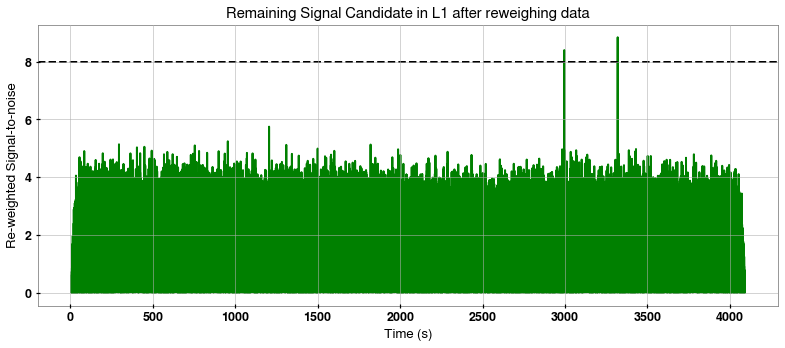

In [42]:
plt.style.use('./plot.mplstyle')    
plt.figure(figsize=[13.27, 5.17])
plt.plot(snr2.sample_times, nsnr2, '-g')
plt.axhline(y = 8, color = 'black', linestyle = 'dashed')
plt.title('Remaining Signal Candidate in L1 after reweighing data')      
plt.xlabel('Time (s)')
plt.ylabel('Re-weighted Signal-to-noise')
plt.show()

In [16]:
import numpy as np
np.set_printoptions(precision=16, suppress=None)

x_max1ar = np.asarray(x_max1l)
x_max2ar = np.asarray(x_max2l)
y_max1ar = np.asarray(y_max1l)
y_max2ar = np.asarray(y_max2l)

#print(x_max1ar)
#print(x_max2ar)
#print(y_max1ar)
#print(y_max2ar)

dfn_1 = pd.DataFrame({'X1':x_max1ar, 'Y1':y_max1ar}).sort_values("X1").reset_index()
dfn_2 = pd.DataFrame({'X2':x_max2ar, 'Y2':y_max2ar}).sort_values("X2").reset_index()

print(dfn_1)
print(dfn_2)

if (len(dfn_1)==0 and len(dfn_2)==0):
  print('There are no remaining signal candidates in both H1 and L1')

elif (len(dfn_1)>0 and len(dfn_2)==0):
  print('There are no surviving signal candidates in L1 whereas for H1 we have',len(dfn_1),"candidates:")
  for i in range(0,dfn_1.index[-1]+1):
     print("There is a signal candidate in H1 at",dfn_1['X1'][i],"with SNR",dfn_1['Y1'][i])
    
elif (len(dfn_2)>0 and len(dfn_1)==0):
  print('There are no surviving signal candidates in H1 whereas for L1 we have',len(dfn_2),"candidates:")
  for j in range(0,dfn_2.index[-1]+1):
     print("There is a signal candidate in L1 at",dfn_2['X2'][j],"with SNR",dfn_2['Y2'][j])

    
elif ((len(dfn_2)>0 and len(dfn_1)>0) and (len(dfn_2)==len(dfn_1))):
    print(color.BLUEB +"The following signal candidates in H1 were ruled out as glitches:" + color.END)
    print(Style.RESET_ALL)
    
    
    
    
    
    print(Style.RESET_ALL)  
    print(color.BLUEB +"The surviving signal candidates in H1 are:" + color.END)
    print(Style.RESET_ALL)
    for i in range(0,dfn_1.index[-1]+1):
       print("There is a signal candidate in H1 at",dfn_1['X1'][i],"with SNR",dfn_1['Y1'][i])  
  
    print(color.GREENB +"The following signal candidates in L1 were ruled out as glitches:" + color.END)
    print(Style.RESET_ALL)
    
    
    
    
    
    print(color.GREENB +"The surviving signal candidates in L1 are:" + color.END)
    print(Style.RESET_ALL)  
    for j in range(0,dfn_2.index[-1]+1):
       print("There is a signal candidate in L1 at",dfn_2['X2'][j],"with SNR",dfn_2['Y2'][j])  
  
    print(Style.RESET_ALL)
    
    print(color.BOLD +"Checking if the surviving signal candidates fit the criteria for a BBH merger for our chosen template:" + color.END)
    #print(Style.RESET_ALL)
    
    for i in range(0,dfn_1.index[-1]+1): 
        for j in range(0,dfn_2.index[-1]+1):              
    
            if dfn_1['X1'][i] == dfn_2['X2'][j]:
                print(Style.RESET_ALL)  
                print("As the timestamps are exactly same we conclude an injected signal mimicking a BBH merger at", dfn_1['X1'][i], 
                      "\nwith the H1 SNR", dfn_1['Y1'][i], "and the L1 SNR", dfn_2['Y2'][j])
                print(Style.RESET_ALL)  
        
            elif dfn_2['X2'][j]-0.008961194 <= dfn_1['X1'][i] <= dfn_2['X2'][j]+0.008961194:
          
                print(Style.RESET_ALL)
                print("We found a BBH merger candidate \nin H1 at", dfn_1['X1'][i], "with SNR",dfn_1['Y1'][i],
                      "and \nin L1 at",dfn_2['X2'][j], "with SNR",dfn_2['Y2'][j])
                print(Style.RESET_ALL)
            
                if abs(dfn_2['X2'][j]-dfn_1['X1'][i]) < 0.008961194:
                    #print(Style.RESET_ALL)
                    print("The time lag",abs(dfn_2['X2'][j]-dfn_1['X1'][i]) ,"s between the signals at H1 & L1 is too short compared to GW travel time and hence \nan artefact of other noise sources or some artificial source")
                    print(Style.RESET_ALL)
            
                else:
                    print(color.BLUEB + "yipee" + color.END)
            
            elif dfn_2['X2'][j]-3 <= dfn_1['X1'][i] <= dfn_2['X2'][j]+3:
            
                if abs(dfn_2['X2'][j]-dfn_1['X1'][i]) > 0.011328301:
                    print(Style.RESET_ALL)
                    print("While the time lag",abs(dfn_2['X2'][j]-dfn_1['X1'][i]) ,"s is short it is too large compared to GW travel time and hence an artefact of other noise sources")
                    print(Style.RESET_ALL) 
                elif ((abs(dfn_2['X2'][j]-dfn_1['X1'][i]) >=0.008961194) and (abs(dfn_2['X2'][j]-dfn_1['X1'][i]) < 0.011328301)): 
                    print(Style.RESET_ALL)
                    print("We found a signal candidate \nin H1 at", dfn_1['X1'][i], "with SNR",dfn_1['Y1'][i],
                          "and \nin L1 at",dfn_2['X2'][j], "with SNR",dfn_2['Y2'][j])
                    print("The above signal is an extremely likely candidate for an authentic BBH merger given the choice of template")
                    print("The time lag",abs(dfn_2['X2'][j]-dfn_1['X1'][i]) ,"s between the signals at H1 & L1 is comparable to GW travel time")
                    print(Style.RESET_ALL)  
                else:
                    print(color.BLUEB + "yipee" + color.END)
            
            elif abs(dfn_2['X2'][j]-dfn_1['X1'][i]) > 3:  
          
                print("The signals at",dfn_1["X1"][i],"for H1 and at",dfn_2["X2"][j],"for L1 are too far apart with a lag of",abs(dfn_2['X2'][j]-dfn_1['X1'][i])," s") 


  

   index           X1         Y1
0      0  2995.342773  10.165441
1      1  3319.255859   8.336510
   index           X2        Y2
0      0  2995.342285  8.021821


In [5]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

sampling_rate=2048 #needs to be high enough for the signals found in steps above
duration=8 #needs to be long enough for the signals found in steps above
start_time=100 #needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1','L1']:
    ifo=bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel=ifo_name+':CHALLENGE3')
    interferometers.append(ifo)

17:48 bilby INFO    : Reading data from frame file challenge3.gwf
17:48 bilby INFO    : Successfully loaded H1:CHALLENGE3.
17:48 bilby INFO    : Reading data from frame file challenge3.gwf
17:48 bilby INFO    : Successfully loaded L1:CHALLENGE3.
